Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.formula.api import ols
from custom_functions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step1_preprocessed'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

In [3]:
df_main.head(3)

,SalePrice,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,SaleInstrument
0,445000,1,1.0,7,1480,0,0,0,0,0,1480,0,0,0,0,440,NaN,80,0,120,5,2,0,NaN,3,0,0,2,1,0,0,0,1994,0,5,3
1,188500,1,1.0,5,550,0,0,0,0,0,550,0,0,0,0,0,NaN,0,0,0,1,1,0,NaN,2,0,1,0,0,0,0,0,1942,0,3,3
2,730000,1,2.0,9,660,0,595,0,0,0,1540,380,285,8,0,0,1.0,0,0,155,1,3,0,1.0,3,1,1,1,0,1,0,0,1984,0,3,3


In [4]:
df_main.columns

Index(['SalePrice', 'NbrLivingUnits', 'Stories', 'BldgGrade', 'SqFt1stFloor',
       'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull',
       'SqFtUnfinHalf', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory',
       'FpMultiStory', 'FpFreestanding', 'FpAdditional', 'YrBuilt',
       'YrRenovated', 'Condition', 'SaleInstrument'],
      dtype='object')

In [5]:
# Understand Square Footage metrics and remove unnecessary/repetitive data

# Isolate columns related to the square footage of the house
sq_footage = df_main[['SqFtTotLiving', 'SqFtTotBasement', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',  'SqFtFinBasement', 'SqFtGarageBasement']].copy()

# Here we see that SqFt isn't just living area + basement area
sq_footage['*TotLiving+TotBasement*'] = df_main.SqFtTotLiving+df_main.SqFtTotBasement 

# Here we see that SqFtTot IS ALWAYS >= SqFtFin+SqFtGarageBasement, as we would hope to be true, otherwise indicating an error
sq_footage.loc[sq_footage['SqFtFinBasement'] > (sq_footage['SqFtTotBasement']+sq_footage['SqFtGarageBasement'])] 

# Here we determine the SqFtTotLiving includes only finished space
finished = ['SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtFinBasement']
unfinished = ['SqFtUnfinFull', 'SqFtUnfinHalf']
sq_footage['livable'] = sq_footage[finished].sum(axis=1) - sq_footage[unfinished].sum(axis=1)
sq_footage.loc[sq_footage.livable != sq_footage.SqFtTotLiving]

# Now we can get rid of SqFt features that are already accounted for with 'summation' features
# All of the metrics can be encompassed in three features: SqFtTotLiving, SqFtTotBasement, SqFtUnfinished
SqFtUnfinished = df_main['SqFtUnfinFull'] + df_main['SqFtUnfinHalf']

In [6]:
# Remove SquareFootage columns determined to be redundant

# Allows the cell to be run multiple times without an error saying the column doesn't exist (because it was already dropped)
sq_ft_cols_to_drop = ['SqFt1stFloor', 'SqFtHalfFloor', 'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFt2ndFloor', 'SqFtGarageBasement', 'SqFtFinBasement']
for col in sq_ft_cols_to_drop:
    if col in df_main.columns:
        df_main.drop(col, axis=1, inplace=True)
        
# Include the "unfinished area" metric since it is data not otherwise accounted for
df_main['SqFtUnfinished'] = SqFtUnfinished

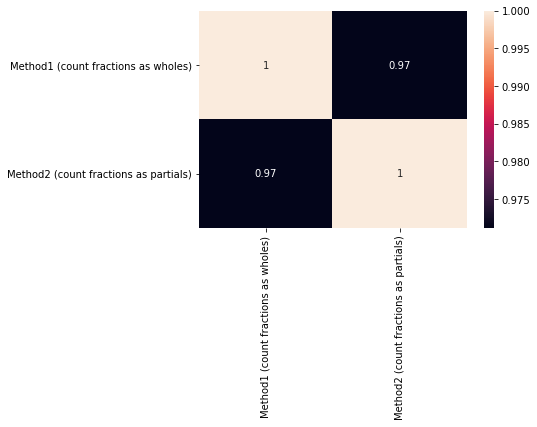

In [7]:
# Aggregate "Bathroom" data

bathrooms_v1 = df_main[['BathHalfCount', 'Bath3qtrCount', 'BathFullCount']].sum(axis=1)
bathrooms_v2 = df_main['BathHalfCount']/2 + df_main['Bath3qtrCount']*3/4 + df_main['BathFullCount']

bathrooms = pd.concat([bathrooms_v1, bathrooms_v2], axis=1)
bathrooms.columns = ['Method1 (count fractions as wholes)', 'Method2 (count fractions as partials)']
corr = bathrooms.corr()
sns.heatmap(corr, annot=True)

# As we can see, it doesn't really matter which method we choose, as they incredibly well correlated, as would be expected
# For the purposes of this analysis, we will use Method 2 so as to not ignore the difference in value that may be
# added by having a smaller bathroom (e.g. "half bath")


# Allows the cell to be run multiple times without an error saying the column doesn't exist (because it was already dropped)
bathroom_cols_to_drop = ['BathHalfCount', 'Bath3qtrCount', 'BathFullCount']
for col in bathroom_cols_to_drop:
    if col in df_main.columns:
        df_main.drop(col, axis=1, inplace=True)

df_main['Bathrooms'] = bathrooms_v2

Current data distribution:
3     18042
15       53
2        30
26       18
Name: SaleInstrument, dtype: int64

This actually means:
Statutory Warranty Deed    18042
Quit Claim Deed               53
Warranty Deed                 30
Other - See Affidavit         18
Name: 0, dtype: int64


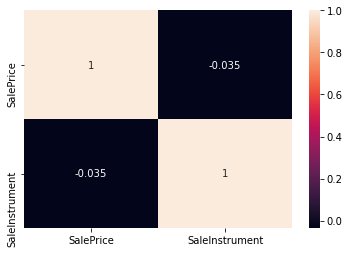

In [9]:
# INVESTIGATE 'SALEINSTUMENT' DATA
print('Current data distribution:')
print(df_main.SaleInstrument.value_counts())

# As we can see, there are very few values other than '3'. Let's investigate what this means
# Import dictionary
codes = get_lookups(LUType=6) # Code 6 corresponds to SaleInstument

# See what the previously-printed codes mean
decoded = pd.DataFrame([codes[str(x)] for x in df_main.SaleInstrument])

print('\nThis actually means:')
print(decoded[0].value_counts())

# Based on these findings, there is no substantial meaning that can be extracted. Before removing
# this data, however, let's make sure there isn't an exceptional correlation with SalePrice
corr = df_main[['SalePrice', 'SaleInstrument']].corr()
sns.heatmap(corr, annot=True)

# Since the heatmap shows there is no correlation, we can confidently remove 'SaleInstrument' from the analysis
if 'SaleInstrument' in df_main.columns:
    df_main.drop('SaleInstrument', axis=1, inplace=True)

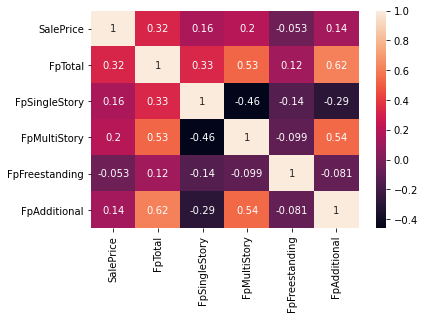

In [10]:
# GAIN UNDERSTANDING OF "FP" MEASUREMENTS

fireplaces = df_main[['FpSingleStory', 'FpMultiStory', 'FpFreestanding', 'FpAdditional']].copy()
fireplaces['FpTotal'] = fireplaces.sum(axis=1)

# Reorder to make Correlation Matrix easier to understand
fireplaces = fireplaces[['FpTotal', 'FpSingleStory', 'FpMultiStory', 'FpFreestanding', 'FpAdditional']]


# Test correlation of Total with individuals
corr = pd.concat([df_main.SalePrice, fireplaces], axis=1).corr()
sns.heatmap(corr, annot=True)


# As we can see, the total number of fireplaces is a much stronger indicator than breaking down into semi-meaningless distinctions
# Drop columns determined to be less valuable
fp_cols_to_drop = ['FpSingleStory', 'FpMultiStory', 'FpFreestanding', 'FpAdditional']
for col in fp_cols_to_drop:
    if col in df_main.columns:
        df_main.drop(col, axis=1, inplace=True)

df_main['Fireplaces'] = fireplaces['FpTotal']

0.0    7418
1.0    4727
Name: DaylightBasement, dtype: int64
na count: 5998


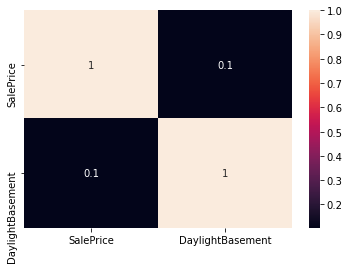

In [11]:
# INVESTIGATE 'DaylightBasement'
# As we can see, there are nearly 6,000 sales (1/3 of our full dataset) that do not have information for this category
# At this point, unless there is a strong correlation with SalePrice, it doesn't make sense to sacrifice that much data

# Create dataframe with relevant data
daylight = df_main[['SalePrice', 'DaylightBasement']]

# Determine number of missing values
print(daylight.DaylightBasement.value_counts())
print('na count:', daylight.shape[0] - daylight.DaylightBasement.value_counts().sum())

# Check correlation
corr = daylight.corr()
sns.heatmap(corr, annot=True);

# Conclusion: drop DaylightBasement from the analysis

if 'DaylightBasement' in df_main.columns:
    df_main.drop('DaylightBasement', axis=1, inplace=True)

0.0    8440
1.0     406
Name: ViewUtilization, dtype: int64
na count: 9297


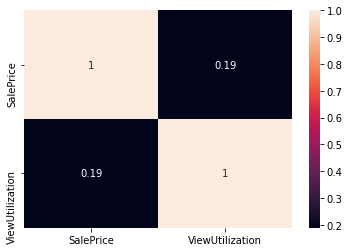

In [12]:
# INVESTIGATE 'ViewUtilization'
# Similar reasoning to DaylightBasement above

view_util = df_main[['SalePrice', 'ViewUtilization']]

# Determine number of missing values
print(view_util.ViewUtilization.value_counts())
print('na count:', view_util.shape[0] - view_util.ViewUtilization.value_counts().sum())

# Check correlation
corr = view_util.corr()
sns.heatmap(corr, annot=True);

# Conclusion
# Although the correlation is higher than DaylightBasement, it still isn't huge. Over half of the dataset does not
# have ViewUtilization data, therefore making it unwise to keep it in the rest of the analysis

df_main.drop('ViewUtilization', axis=1, inplace=True)

In [13]:
# *** WRITE TO SQL DB ***

conn = sqlite3.connect('../../data/processed/main.db')
df_main.to_sql('step2_encoded', conn, if_exists='replace')
conn.close()
# ******